# **Speaker Classification using Pitch and MFCCs**

Harvard AI Bootcamp

## Make a copy of this notebook! Editing directly will not be saved.

Speaker-dependent classification is a problem that involves finding unique characteristics of an individual's voice. We will use pitch and mel-frequency cepstral coefficients to do so (MFCCs).

We will use a simple K-nearest-neighbors (KNN) model, which labels a data point based on it's K-nearest-neighbors (calculated using distance formula).

CMU Arctic Speaker Recognition Dataset: https://www.kaggle.com/datasets/mrgabrielblins/speaker-recognition-cmu-arctic?select=test_full.csv

Additional MFCC resources/coding examples:
1.   https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial
2.   https://musicinformationretrieval.com/mfcc.html

# *Setting Up: Downloading Data + Viewing Audio*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

Create a Kaggle account if you haven't yet. Follow the steps in the link and cells below to upload the CMU Arctic Speaker Recognition Dataset: https://www.kaggle.com/general/371462


Import everything in the cells below. Note: some of these imports will only be used for extensions.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mrgabrielblins/speaker-recognition-cmu-arctic

In [ ]:
from zipfile import ZipFile
file_name = 'speaker-recognition-cmu-arctic.zip' #the file is your dataset's exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
# librosa will be used for all pre-processing
!pip install librosa

# these are only needed for extensions
!pip install pydub
!apt-get -qq install -y sox
!pip install sox

In [ ]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import math
import sox
from pydub import AudioSegment, effects

In [ ]:
# try loading a sample audio and listening to it
TRAIN_PATH = '/content/train/'
audio_file = 'aew/arctic_a0003.wav'
ipd.Audio(TRAIN_PATH + audio_file)

In [ ]:
# some basic information like sample rate and audio duration
audio, sample_rate = librosa.load(TRAIN_PATH+audio_file, sr=16000)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Normalizing the audio is tricky. Based on your dataset, try different normalization techniques.

A simple one that works well for the CMU dataset is just scaling everything using the maximum value.

In other cases, librosa.util.normalize() may work better. API: https://librosa.org/doc/main/generated/librosa.util.normalize.html

In [ ]:
# normalize the audio
def normalize_audio(audio):
    # TODO
    # hint: for the CMU Arctic dataset, just divide by the absolute max of the audio
    audio = audio / np.max(np.abs(audio))
    # END TODO
    return audio

    # OR use librosa:

    # range = np.amax(audio) - np.amin(audio)
    # audio_new = (audio-np.amin(audio))/range
    # audio_new = audio_new*2-1
    # return audio_new

In [ ]:
# view the normalized audio
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

# *Preprocessing Data*

Our model will use pitch and mel-frequency cepstral coefficients (MFCCs). Pitch is the same as what you typically think of—higher frequency is higher pitch, and vice-versa.

MFCCs are determined based on a linear cosine transform of a log power spectrum on a non-linear scale of frequency. Empirically, they're used to describe the "timber" of a sound. (Check top of the notebook for more resources)

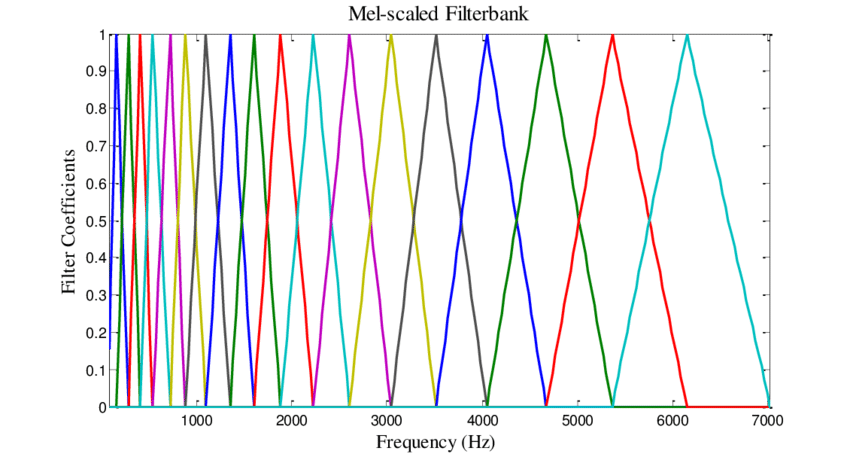

Notice the filters overlap one another, which makes the output smoother.

In [ ]:
# we don't want to keep silence/unvoiced sounds: librosa's PYIN function automatically flags those and removes them
# API for librosa.pyin(): https://librosa.org/doc/latest/generated/librosa.pyin.html
def detect_pitch(y, sr=16000):
  # TODO use librosa.pyin() for this
  f0, voiced_flag, voiced_prob = librosa.pyin(y=y, sr=sr, fmin=75, fmax=1600, frame_length=2048)
  # END TODO
  return f0, voiced_flag, voiced_prob

In [ ]:
def create_data(speaker, audio):

  # TODO
  # use the detect_pitch function (1-line)
  fundamentals, is_voiced, prob_voiced = detect_pitch(audio)

  # only keeped the voiced parts (1-line)
  fundamentals = fundamentals[is_voiced]

  # API for librosa.mfcc(): https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
  # you can experiment with the number of MFCCs, but start with 13
  # Note: you need to use np.transpose() on mfccs so dimensions line up with pitch data
  mfccs = np.transpose(librosa.feature.mfcc(y=audio, n_mfcc=13, sr=16000))
  mfccs = mfccs[is_voiced]
  d0 = {'speaker': [speaker]*len(fundamentals), 'pitch': fundamentals}
  for i in range(len(mfccs[0])):
    d0['mfcc_'+str(i)] = mfccs[:,i]

  dataset = pd.DataFrame(data=d0)
  return dataset

In [ ]:
# main use is for creating training sets
def create_dataset(speaker_list, n_files):
  speaker_data = pd.DataFrame()
  # create a for loop that iterates through the length of the speaker_list
  # to get the list of audio files, use os.listdir(): https://www.geeksforgeeks.org/python-os-listdir-method/
  for i in range(len(speaker_list)):
    # path to the train set for each speaker
    path = '/content/train/' + speaker_list[i] + '/'
    list_of_files = os.listdir(path)
    # only keep the first n files
    list_of_files = list_of_files[0:n_files]

    for filename in list_of_files:
      audio, sample_rate = librosa.load(path + filename, sr=16000)
      audio = normalize_audio(audio)
      speaker_data = pd.concat([speaker_data, create_data(speaker_list[i], audio)])

  speaker_data.reset_index(inplace=True)
  column_names = list(speaker_data.columns)[2:]
  # we need to scale the data if we're using the distance formula; otherwise, each dimension will be treated unequally
  # use MinMaxScaler to scale between 0 and 1: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(speaker_data.iloc[:,2:])
  scaled_data = pd.DataFrame(scaled_data, columns=column_names)
  speaker_data = pd.concat([speaker_data.loc[:,'speaker'], scaled_data], axis=1)

  return speaker_data

In [ ]:
# general test dataset that takes the first n number of files in the csv for each speaker
def create_test_dataset(speaker_list, n_files):
  speaker_data = pd.DataFrame()
  test_csv = pd.read_csv('/content/test_full.csv').iloc[:,1:]
  for speaker in speaker_list:
    speaker_files = test_csv[test_csv['speaker']==speaker]
    speaker_files = speaker_files.iloc[:n_files]
    speaker_files = speaker_files['file_path']
    for _, filename in speaker_files.items():
      audio, sample_rate = librosa.load('/content/'+filename, sr=16000)
      audio = normalize_audio(audio)
      speaker_data = pd.concat([speaker_data, create_data(speaker, audio)])

  speaker_data.reset_index(inplace=True)
  column_names = list(speaker_data.columns)[2:]
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(speaker_data.iloc[:,2:])
  scaled_data = pd.DataFrame(scaled_data, columns=column_names)
  speaker_data = pd.concat([speaker_data.loc[:,'speaker'], scaled_data], axis=1)

  return speaker_data

In [ ]:
# create your training and testing sets
my_train_data = create_dataset(['aew', 'axb'], 10)
my_test_data = create_test_dataset(['aew', 'axb'], 2)

In [ ]:
# save your data, repeat for test data
from pathlib import Path
filepath = Path('/content/drive/data/my_example_train_data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
my_train_data.to_csv(filepath)

filepath1 = Path('/content/drive/data/my_example_test_data.csv')
filepath1.parent.mkdir(parents=True, exist_ok=True)
my_test_data.to_csv(filepath1)

# *Finding the K value for your KNN Model*

You might not want to always use this K value. Example: If you have two speakers and your K-value is 2, the model will use the neighbor that chronologically comes first (however you ordered your dataset), adding bias.

In [ ]:
df = pd.read_csv('/content/drive/data/my_example_train_data.csv')
X = df.iloc[:, 2:]
speakers = {'aew': 0, 'axb': 1}
y = df.iloc[:,1]
y = y.replace(speakers)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
# fit the test data for various K's
Ks = 20
mse = np.zeros((Ks-1))
rmse = np.zeros((Ks-1))
scores = np.zeros((Ks-1))
for n in range(1, Ks):
  # TODO
  # Declare and train an KNN Regressor with n neighbor
  knnRegress = KNeighborsRegressor(n_neighbors=n)
  knnRegress.fit(X_train, y_train)
  # Store the KNN predictions on X_test
  yhat = knnRegress.predict(X_test)
  # Calculate score
  scores[n-1] = knnRegress.score(X_test, y_test)
  print('k=', n, 'score=', scores[n-1])
  # Calculate MSE and RMSE
  mse[n-1] = (((yhat - y_test) ** 2).sum())/len(yhat)
  rmse[n-1] = math.sqrt(mean_squared_error(y_test, yhat))
  print('rmse: ', rmse[n-1])
  # END TODO
K = rmse.argmin()+1
print('Lowest rmse and associated K: RMSEmin = ', rmse.min(), ' K = ', K)
plt.scatter(np.arange(1,20,1),rmse)
plt.show()

# *Testing*

In [ ]:
# compute the KNN algorithm for one data point
def pred_file(test_row, training_frame, K):
  temp = training_frame.iloc[:,1:]
  test_row = test_row.iloc[1:]
  dist = np.full((len(training_frame),2),0.0)
  for n in range(1, len(training_frame)+1):
    dist[n-1,0] = n
    for col in temp:
      dist[n-1,1] += (test_row[col]-temp[col][n-1])**2
    dist[n-1,1] = math.sqrt(dist[n-1,1])
  distSorted = dist[dist[:,1].argsort()]
  predSpeaker = statistics.mode(training_frame['speaker'][distSorted[0:K,0]-1])
  return predSpeaker

In [ ]:
# make predictions for each data point in the test frame, then return those predictions as a list
def pred_speaker(test_frame, training_frame, speaker, K, dummies):
  tf = test_frame.loc[test_frame['speaker']==speaker]
  tf = tf.iloc[:, 1:]
  y = training_frame['speaker']
  y = y.replace(dummies)
  train_frame = pd.concat([y,training_frame.iloc[:,2:]],axis=1)
  train_frame.rename(columns={train_frame.columns[0]: 'speaker'}, inplace=True)
  predictions = []
  for i in range(tf.shape[0]):
    predictions.append(pred_file(tf.iloc[i], train_frame, K))
  return predictions

In [ ]:
speakers = {'aew': 0, 'axb': 1}

K = 3

df = pd.read_csv('/content/drive/data/my_example_train_data.csv').iloc[:,1:]
df2 = pd.read_csv('/content/drive/data/my_example_test_data.csv').iloc[:,1:]

p = []
for speaker in speakers:
  p.append(pred_speaker(df2, df, speaker, K, speakers))
  id = speakers[speaker]
  print('Test for', speaker)
  # print the percent of data points the KNN accurately labeled
  print('Percentage correct:', p[id].count(id)/len(p[id])*100, "%")
  # to see details
  for s in speakers:
    # for each speaker, which percent of the labels was classified as such?
    print('\tPercent classified as', s, ':', p[id].count(speakers[s])/len(p[id])*100, "%")
  print('')

# *Extensions*

Some ideas for extensions:

1.   Mixing different speakers' voices for either training or testing data
2.   Creating your own dataset using you and your classmates' voices
3.   Using different test speakers than found in the train set

Or come up with your own!

Hints for extensions:

For most extensions, you'll need to modify the create_dataset/create_train_dataset functions, as you may have files in your Google Drive instead of pulling from the Kaggle dataset. Additionally, the prediction functions/how you use them will need to be changed, as the test speakers won't perfectly align with the train speakers.

***Mixing***

Use the sox library. Check out the combiner function: https://pysox.readthedocs.io/en/latest/example.html

Note: the example converts to stereo, but you don't need that, it will only take up more data, so just set n_channels to 1 for mono audio.

***Creating your own dataset***

Download an audio recording app that uses wav (iPhone's default app is m4a), or if you have your own quality microphones, even better! For normalizing, librosa.util.normalize() may work better, as the quality of the recordings will not be as good as the CMU Arctic dataset.

If you process the final audio through a digital audio workspace (DAW) like Garageband, the file may be incompatible with Colab's environment. First, re-convert it to wav through an online wav converter. Then, since it might be stereo, it will stop your runtime by using too much RAM. You'll need to convert it to mono either with sox, pydub, or some other library. PyDub AudioSegment: https://stackoverflow.com/questions/5120555/how-can-i-convert-a-wav-from-stereo-to-mono-in-python

For most extensions, this extra function/some variation of it will be needed, which creates a specific dataset based on specific names of each file.

In [ ]:
# creates a test dataset with specific files
def create_specific_test_dataset(list_of_files, speaker_list, special_path=None):
  speaker_data = pd.DataFrame()
  for i in range(len(list_of_files)):
    # using a special path, in case the files are in Google Drive, etc.
    # otherwise assumes them to be in the CMU dataset
    if special_path is None:
      path = '/content/test/' + list_of_files[i]

    else:
      path = special_path + list_of_files[i]
    audio, sample_rate = librosa.load(path, sr=16000)
    audio = normalize_audio(audio)

    speaker_data = pd.concat([speaker_data, create_data(speaker_list[i], audio)])

  speaker_data.reset_index(inplace=True)
  column_names = list(speaker_data.columns)[2:]
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(speaker_data.iloc[:,2:])
  scaled_data = pd.DataFrame(scaled_data, columns=column_names)
  speaker_data = pd.concat([speaker_data.loc[:,'speaker'], scaled_data], axis=1)

  return speaker_data

## **Mixing Audio**

In [ ]:
# creating a dataset that includes mixed audio saved in Google Drive
def create_dataset(speaker_list, conditions, n_files, mixed_files=10):
  # conditions is a list with same length as speaker_list. 1 indicates mixed, 0 is not
  speaker_data = pd.DataFrame()
  for i in range(len(speaker_list)):
    path = ''
    if conditions[i] == 0:
      path = '/content/train/' + speaker_list[i] + '/'
    else:
      # this path needs to be changed to where their mixed audio is stored
      path = '/content/drive/Audio/data/' + speaker_list[i] + '/'
    list_of_files = os.listdir(path)
    if conditions[i] == 0:
      list_of_files = list_of_files[0:n_files]
    else:
      list_of_files = list_of_files[0:mixed_files]

    for filename in list_of_files:
      audio, sample_rate = librosa.load(path + filename, sr=16000)
      audio = normalize_audio(audio)
      speaker_data = pd.concat([speaker_data, create_data(speaker_list[i], audio)])

  speaker_data.reset_index(inplace=True)
  column_names = list(speaker_data.columns)[2:]
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(speaker_data.iloc[:,2:])
  scaled_data = pd.DataFrame(scaled_data, columns=column_names)
  speaker_data = pd.concat([speaker_data.loc[:,'speaker'], scaled_data], axis=1)

  return speaker_data

In [ ]:
# function to mix the audio
def mix_audio(speaker_list, n_files, storage_path):
  speaker_data = pd.DataFrame()
  cbn = sox.Combiner()
  cbn.convert(samplerate=16000, n_channels=1)
  paths = []
  lists_of_files = []
  masterpath = '/content/train/'
  for i in range(len(speaker_list)):
    paths.append('/content/train/' + speaker_list[i] + '/')
    lists_of_files.append(os.listdir(paths[i]))
    masterpath += speaker_list[i]
    if i < len(speaker_list)-1:
      masterpath += '_'
  final_list = set(lists_of_files[0])
  for i in range(1, len(speaker_list)):
    final_list = final_list.intersection(set(lists_of_files[i]))
  final_list = list(final_list)[0:n_files]
  masterpath += '/'
  for n in range(n_files):
    file_list = []
    for j in range(len(paths)):
      file_list.append(paths[j] + final_list[n])
    cbn.build(file_list, storage_path + 'output'+str(n)+str(j)+'.wav', 'mix')

### **Train with Individuals, Test Mixed**

In [ ]:
# code for testing
dummies = {'aew': 0, 'axb': 1, 'ksp': 2, 'clb': 3, 'gka': 4, 'lnh': 5, 'jmk': 6, 'slp': 7}
test_speakers = {'aewaxb': ['aew', 'axb'], 'kspclb': ['ksp', 'clb'], 'jmk': ['jmk'], 'slp': ['slp']}

df = pd.read_csv('/content/drive/data/aew_axb_ksp_clb_gka_lnh_train.csv').iloc[:,1:]
df2 = pd.read_csv('/content/drive/Audio/data/aewaxb_kspclb_jmk_slp_test.csv').iloc[:,1:]

p = []
speaker_num = 0
for speaker in test_speakers:
  p.append(pred_speaker(df2, df, speaker, K, dummies))
  print('Test for', speaker)
  correct = 0
  for individual in test_speakers[speaker]:
    correct += p[speaker_num].count(dummies[individual])
  print('Percentage correct:', correct/len(p[speaker_num])*100, "%")
  # to see details
  for s in dummies:
    print('\tPercent classified as', s, ':', p[speaker_num].count(dummies[s])/len(p[speaker_num])*100, "%")
  print('')
  speaker_num += 1

## **Creating your own dataset**
The website I used for wav conversion from GarageBand into stereo files saved into drive (before turning into mono): https://cloudconvert.com/wav-converter

In [ ]:
# how to fix incompatible file types
path = '/content/drive/Audio/data/fam/' # change this path to where the files are located
list_of_files = os.listdir(path)
for my_file in list_of_files:
  sound = AudioSegment.from_wav(path + my_file)
  sound = sound.set_channels(1)
  sound.export(path + my_file, format="wav")